In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/train.zip" -d "/content/data"


In [3]:
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
# Загрузка настроек
with open('/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = config['training']['batch_size']
early_stopping_patience = config['training']['patience']
learning_rate = config['training'].get('learning_rate', 1e-4)
weight_decay = config['training'].get('weight_decay', 0.0)


root_dir = '/content/data/train'

In [6]:
# Путь к данным
train_csv = config['dataset']['train_csv']
df = pd.read_csv(train_csv)

In [7]:
df['true_label'] = df['true_label'].astype(int)
print("Распределение классов:")
print(df['true_label'].value_counts())

Распределение классов:
true_label
0    18867
1    12520
2     6260
Name: count, dtype: int64


In [8]:
from torchvision import transforms
from PIL import Image
import os



def get_transform_pipeline(config, label=None):
    transform_list = []

    transform_config = config.get('train_transforms', {})
    common_transforms = transform_config.get('common', [])
    transform_list.extend(parse_transforms(common_transforms, config))

    # Классы 1 и 2 получают сильные аугментации
    if label in [1, 2]:
        label_key = str(label)
        class_specific = transform_config.get(label_key, [])
        transform_list.extend(parse_transforms(class_specific, config))

    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)

def parse_transforms(transform_names, config):
    transform_ops = []
    image_size = config['dataset']['image_size']
    transform_ops.append(transforms.Resize(image_size))

    for name in transform_names:
        if name == "horizontal_flip":
            transform_ops.append(transforms.RandomHorizontalFlip())
        elif name == "vertical_flip":
            transform_ops.append(transforms.RandomVerticalFlip())
        elif name == "color_jitter":
            transform_ops.append(transforms.ColorJitter(0.3, 0.3, 0.2, 0.1))
        elif name == "random_affine":
            transform_ops.append(transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5))
        elif name == "gaussian_blur":
            transform_ops.append(transforms.GaussianBlur(kernel_size=3))
        elif name == "random_erasing":
            transform_ops.append(transforms.RandomErasing(p=0.2))
        else:
            raise ValueError(f"Неизвестная трансформация: {name}")

    return transform_ops



In [9]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        # Возвращаем изображение, метку и имя файла
        return image, label, img_name


In [10]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, config, fold=0):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    early_stopping_patience = config['training'].get('early_stopping_patience', 3)
    model_save_path = config['training'].get('model_save_path', 'checkpoints/')
    num_epochs = config['training'].get('num_epochs', 20)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    scaler = GradScaler()  # грузим датасет

    if hasattr(model, 'vit'):
        for param in model.vit.parameters():
            param.requires_grad = False

    for epoch in range(num_epochs):
        if epoch == config['training'].get('freeze_encoder_epochs', 3):
            if hasattr(model, 'vit'):
                for param in model.vit.parameters():
                    param.requires_grad = True

        model.train()
        running_train_loss = 0.0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # train
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_labels, all_preds, all_probs, image_names = [], [], [], []

        with torch.no_grad():
            for inputs, labels, filenames in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():  # val
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    loss = criterion(logits, labels)

                running_val_loss += loss.item()

                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                image_names.extend(filenames)

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            save_path = os.path.join(model_save_path, f"baseline_vit_fold{fold + 1}.pth")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)  # <--- эта строка создаёт директорию, если нужно
            torch.save(model.state_dict(), save_path)

        elif epoch > 0 and avg_val_loss > best_val_loss and avg_train_loss < train_losses[-2]:
            patience_counter += 1
            print(f"Validation loss ↑ while train loss ↓. Patience {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered due to overfitting.")
                break

    # Final metrics
    num_classes = len(set(all_labels))
    print("\nFinal Metrics on Validation Set:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(all_labels, all_preds):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}")

    # AUC-ROC
    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
        print(f"AUC-ROC (OvR, macro): {auc:.4f}")
    except Exception as e:
        print(f"AUC-ROC calculation failed: {e}")

    plot_training_history(train_losses, val_losses)
    return all_labels, all_preds, all_probs, image_names


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-d92d42b19721>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-d92d42b19721>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # train
<ipython-input-11-d92d42b19721>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # val


Epoch 1/50 | Train Loss: 1.1078 | Val Loss: 1.1059
Epoch 2/50 | Train Loss: 1.1011 | Val Loss: 1.0996
Epoch 3/50 | Train Loss: 1.0948 | Val Loss: 1.0936
Epoch 4/50 | Train Loss: 1.0100 | Val Loss: 0.9465
Epoch 5/50 | Train Loss: 0.8937 | Val Loss: 0.8447
Epoch 6/50 | Train Loss: 0.7868 | Val Loss: 0.7242
Epoch 7/50 | Train Loss: 0.6574 | Val Loss: 0.6049
Epoch 8/50 | Train Loss: 0.5596 | Val Loss: 0.5307
Epoch 9/50 | Train Loss: 0.5009 | Val Loss: 0.4893
Epoch 10/50 | Train Loss: 0.4647 | Val Loss: 0.4595
Epoch 11/50 | Train Loss: 0.4390 | Val Loss: 0.4401
Epoch 12/50 | Train Loss: 0.4195 | Val Loss: 0.4244
Epoch 13/50 | Train Loss: 0.4046 | Val Loss: 0.4123
Epoch 14/50 | Train Loss: 0.3933 | Val Loss: 0.4028
Epoch 15/50 | Train Loss: 0.3836 | Val Loss: 0.3960
Epoch 16/50 | Train Loss: 0.3754 | Val Loss: 0.3900
Epoch 17/50 | Train Loss: 0.3682 | Val Loss: 0.3839
Epoch 18/50 | Train Loss: 0.3622 | Val Loss: 0.3811
Epoch 19/50 | Train Loss: 0.3564 | Val Loss: 0.3771
Epoch 20/50 | Train L

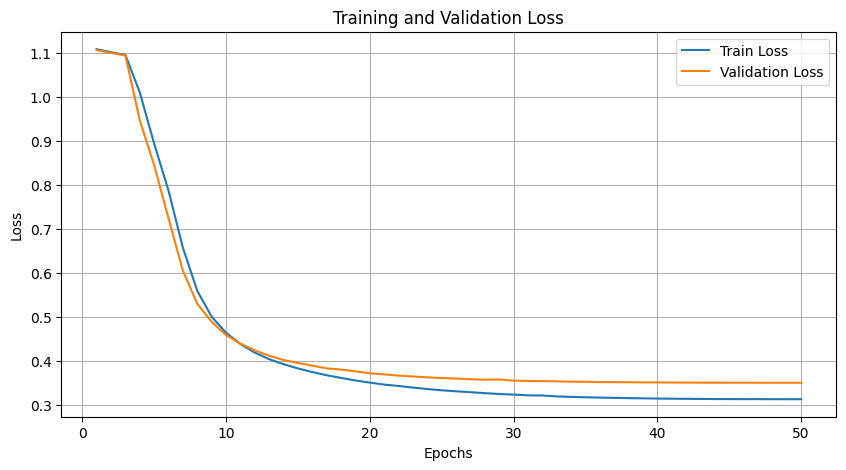


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-d92d42b19721>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-d92d42b19721>:3

Epoch 1/50 | Train Loss: 1.0640 | Val Loss: 1.0621
Epoch 2/50 | Train Loss: 1.0588 | Val Loss: 1.0573
Epoch 3/50 | Train Loss: 1.0542 | Val Loss: 1.0530
Epoch 4/50 | Train Loss: 0.9822 | Val Loss: 0.9276
Epoch 5/50 | Train Loss: 0.8694 | Val Loss: 0.8177
Epoch 6/50 | Train Loss: 0.7559 | Val Loss: 0.7044
Epoch 7/50 | Train Loss: 0.6476 | Val Loss: 0.6076
Epoch 8/50 | Train Loss: 0.5648 | Val Loss: 0.5420
Epoch 9/50 | Train Loss: 0.5104 | Val Loss: 0.5011
Epoch 10/50 | Train Loss: 0.4753 | Val Loss: 0.4743
Epoch 11/50 | Train Loss: 0.4505 | Val Loss: 0.4555
Epoch 12/50 | Train Loss: 0.4328 | Val Loss: 0.4412
Epoch 13/50 | Train Loss: 0.4185 | Val Loss: 0.4288
Epoch 14/50 | Train Loss: 0.4061 | Val Loss: 0.4192
Epoch 15/50 | Train Loss: 0.3964 | Val Loss: 0.4119
Epoch 16/50 | Train Loss: 0.3891 | Val Loss: 0.4073
Epoch 17/50 | Train Loss: 0.3814 | Val Loss: 0.4014
Epoch 18/50 | Train Loss: 0.3751 | Val Loss: 0.3970
Epoch 19/50 | Train Loss: 0.3703 | Val Loss: 0.3933
Epoch 20/50 | Train L

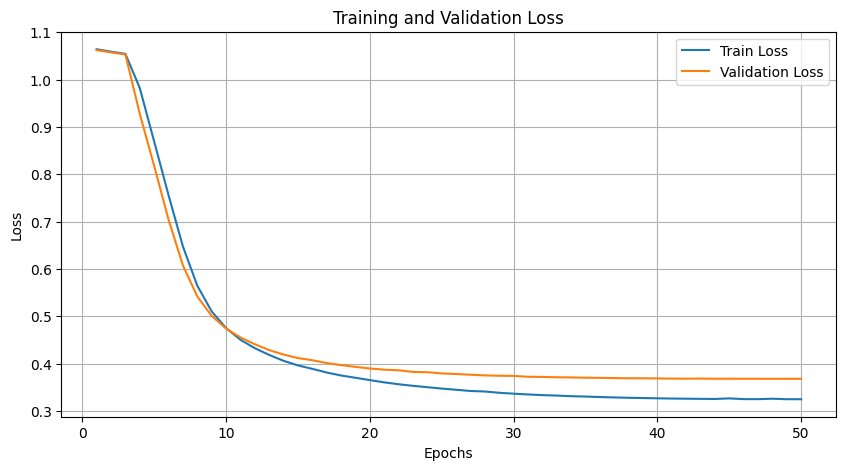


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-d92d42b19721>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-d92d42b19721>:3

Epoch 1/50 | Train Loss: 1.1099 | Val Loss: 1.1057
Epoch 2/50 | Train Loss: 1.1031 | Val Loss: 1.0994
Epoch 3/50 | Train Loss: 1.0967 | Val Loss: 1.0934
Epoch 4/50 | Train Loss: 1.0106 | Val Loss: 0.9511
Epoch 5/50 | Train Loss: 0.8898 | Val Loss: 0.8293
Epoch 6/50 | Train Loss: 0.7556 | Val Loss: 0.6806
Epoch 7/50 | Train Loss: 0.6188 | Val Loss: 0.5706
Epoch 8/50 | Train Loss: 0.5338 | Val Loss: 0.5101
Epoch 9/50 | Train Loss: 0.4857 | Val Loss: 0.4734
Epoch 10/50 | Train Loss: 0.4549 | Val Loss: 0.4499
Epoch 11/50 | Train Loss: 0.4325 | Val Loss: 0.4324
Epoch 12/50 | Train Loss: 0.4173 | Val Loss: 0.4203
Epoch 13/50 | Train Loss: 0.4043 | Val Loss: 0.4125
Epoch 14/50 | Train Loss: 0.3944 | Val Loss: 0.4034
Epoch 15/50 | Train Loss: 0.3859 | Val Loss: 0.3966
Epoch 16/50 | Train Loss: 0.3772 | Val Loss: 0.3939
Epoch 17/50 | Train Loss: 0.3710 | Val Loss: 0.3862
Epoch 18/50 | Train Loss: 0.3657 | Val Loss: 0.3851
Epoch 19/50 | Train Loss: 0.3602 | Val Loss: 0.3781
Epoch 20/50 | Train L

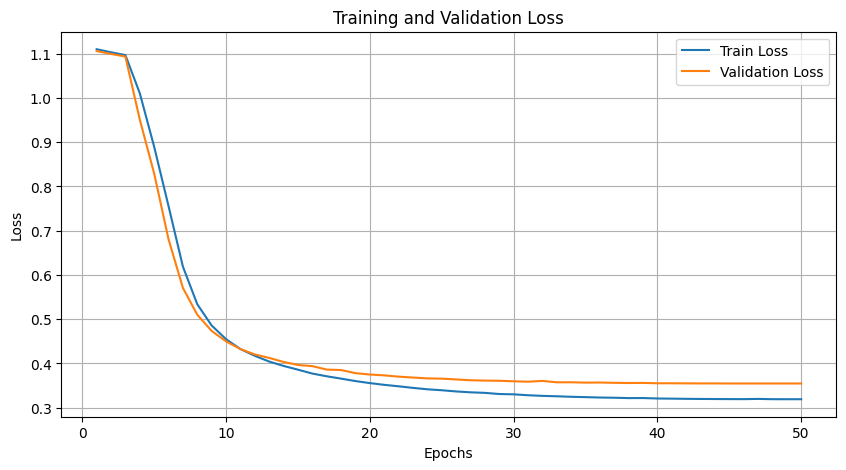


 Все фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'


In [12]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import os

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
all_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['true_label'])):
    print(f"\n====== Fold {fold + 1} ======")

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # --- Создание датасетов и загрузчиков ---
    train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
    val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=22, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=22, pin_memory=True)

    # --- Создание модели ---
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k", num_labels=3, ignore_mismatched_sizes=True
    )
    model.to(device)

    # --- Оптимизатор и шедулер ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler_type = config['training'].get('scheduler', 'cosine').lower()
    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['training']['num_epochs'])
    elif scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_type}")

    # --- Обновляем путь для сохранения модели ---
    config['training']['model_save_path'] = f"best_model_fold{fold + 1}.pth"

    # --- Обучение модели на фолде ---
    labels, preds, probs, image_names = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, config, fold=fold
    )

    # --- Сохраняем предсказания фолда ---
    fold_df = pd.DataFrame({
        'image_name': image_names,
        'true_label': labels,
        'pred_label': preds,
        'fold': fold + 1
    })
    all_results.append(fold_df)

# --- Объединяем и сохраняем ---
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("kfold_vit_predictions.csv", index=False)
print("\n Все фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'")
